In [17]:
%load_ext autoreload
%autoreload 2
import load_prism
import load_tether
import torch
import yaml
import logging
import matplotlib.pyplot as plt
from liftpose.vision_3d import *
from liftpose.preprocess import concat_dict, total_frames, center_poses, anchor_to_root, flatten_dict, unflatten_dict
from liftpose.plot import plot_pose_3d, plot_pose_2d
from tqdm import tqdm
tqdm.get_lock().locks = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data in the source domain (tethered fly) and rotate it to ventral camera angle

In [18]:
# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D_prism', # change the path 
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/domain_adaptation',
               'train_subjects' : ['Fly1','Fly2'],
               'actions'        : ['all']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par_source = {**par_data["data"], **par_train}

# Load 3D data
pts3d_source = load_tether.load_3D(
    par_source["data_dir"],
    par_source,
    subjects=par_source["train_subjects"],
    actions=par_source["actions"],
)

#center
pts3d_source = center_poses(pts3d_source)

#concatenate dicts of experiments
pts3d_source = concat_dict(pts3d_source)

#roots are bit wobbly across frames so stabilize them by anchoring and then adding the root for frame #1
#pts3d_source = flatten_dict(pts3d_source)
#pts3d_source, offset = anchor_to_root(pts3d_source, par_source['roots'], par_source['target_sets'], 3)
#k0 = None
#for k in pts3d_source.keys():
#    if k0 is None:
#        k0=k
#    pts3d_source[k] += offset[k0][0,:]

#pts3d_source = unflatten_dict(pts3d_source,3)    
#pts3d_source = pts3d_source['']

#project to ventral view

intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 
tvec = np.array([0, 0, 117])
pts2d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy', project=True, tvec=tvec, intr=intr)
pts3d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy')


# Load data in the target domain (fly in prism-mirror setup)

In [19]:
# declare data parameters
par_train = {'data_dir'       : "/data/LiftPose3D/fly_tether/data_DF3D_prism/", # change the path
             'out_dir'        : '/data/LiftPose3D/domain_adaptation',
             "train_subjects" : ['Flyprism1','Flyprism2'],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
pts3d_target, keypts_target, _ = load_prism.load_3D(par["data_dir"], 
                                            subjects=par['train_subjects'], 
                                            actions=par['actions'])

#center
pts3d_target = center_poses(pts3d_target)

#concatenate dicts of experiments
pts3d_target = concat_dict(pts3d_target)
keypts_target = concat_dict(keypts_target)

#L = [i for i in range(15)]
#R = [i for i in range(15,30)]

#select only high confidence points with roots
#ind = ((keypts_target[:,L,:].max(2).sum(1)==15) | (keypts_target[:,R,:].max(2).sum(1)==15)) & (keypts_target[:,par['roots'],:].max(2).sum(1)==3)
#pts3d_target = pts3d_target[ind]
#keypts_target = keypts_target[ind]

#roots are bit wobbly across frames so stabilize them by anchoring and then adding the root for frame #1
pts3d_target = flatten_dict(pts3d_target)
#pts3d_target, offset = anchor_to_root(pts3d_target, par['roots'], par['target_sets'], 3)
#k0 = None
#for k in pts3d_target.keys():
#    if k0 is None:
#        k0=k
#    pts3d_target[k] += offset[k0][0,:]
    
pts3d_target = unflatten_dict(pts3d_target,3)

#project data to ventral view
pts2d_target = XY_coord_dict(pts3d_target)

pts2d_target = pts2d_target['']
pts3d_target = pts3d_target['']

ind = [i for i in range(2000,6000)]
#ind = [i for i in range(0,500)]
pts2d_target = pts2d_target[ind]
pts3d_target = pts3d_target[ind]
keypts_target = keypts_target[ind]

In [ ]:
ind = 10

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plot_pose_2d(
    ax, 
    test_pose[ind], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)

In [ ]:
idx =0

fig = plt.figure(figsize=plt.figaspect(1), dpi=50)
ax = fig.add_subplot(111, projection='3d')
plot_pose_3d(ax=ax, tar=pts3d_target[idx],
        #pred=pred,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"],
        good_keypts = keypts_target[idx],
        normalize=False,
        legend=True,
        axes=True)

In [ ]:
%matplotlib inline

from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=50)
ax = fig.add_subplot(111)#, projection='3d')
#ax.view_init(elev=30, azim=140)

def f(ax, idx):
    ax.cla()

    #plot_pose_3d(ax=ax, tar=pts3d_target[idx],
    #    #pred=pred,
    #    bones=par_data["vis"]["bones"], 
    #    limb_id=par_data["vis"]["limb_id"], 
    #    colors=par_data["vis"]["colors"],
    #    #good_keypts = keypts_target[idx],
    #    normalize=False,
    #    legend=True,
    #    axes=True)
    
    plot_pose_2d(
        ax, 
        test_pose[idx],#tar[idx,:,:2], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
    colors=par_data["vis"]["colors"], 
    )
    #ax.set_xlim([-200,200])
    #ax.set_ylim([-200,200])
    #ax.set_zlim([-40,40])
    
plot_video_3d(fig, ax, n=250, fps=20, draw_function=f, name='LiftPose3D_prediction.mp4')

# Find nearest neighbours

In [4]:
#pts2d_source = torch.load('test_2d_DF3D.pth.tar')
#pts2d_target = torch.load('test_2d_prism.pth.tar')
pts3d_source = torch.load('test_3d_DF3D.pth.tar')
pts3d_target, keypts_target = torch.load('test_3d_prism.pth.tar')

#pts2d_source = np.concatenate([v for k,v in pts2d_source.items()], 0)
#pts2d_target = np.concatenate([v for k,v in pts2d_target.items()], 0)
pts3d_source = np.concatenate([v for k,v in pts3d_source.items()], 0)
pts3d_target = np.concatenate([v for k,v in pts3d_target.items()], 0)
keypts_target = np.concatenate([v for k,v in keypts_target.items()], 0)

#pts2d_source = pts2d_source.reshape(pts2d_source.shape[0],pts2d_source.shape[1]//2, 2)
#pts2d_target = pts2d_target.reshape(pts2d_target.shape[0],pts2d_target.shape[1]//2, 2)
pts3d_source = pts3d_source.reshape(pts3d_source.shape[0],pts3d_source.shape[1]//3, 3)
pts3d_target = pts3d_target.reshape(pts3d_target.shape[0],pts3d_target.shape[1]//3, 3)
keypts_target = np.tile(keypts_target[:,:,None],3)

pts3d_source = project_to_eangle(pts3d_source, [-90,0,0], axsorder='xzy')

In [7]:
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle

nn = 20
frac_samples = 0.05

try:
    poses, nns_2d, nns_3d = pickle.load(open(par_train['out_dir']+'/neighbors.pkl','rb'))
    print('loaded existing neighbor data')

except:
    total = pts3d_target.shape[0]
    poses = [i for i in range(int(frac_samples*total))]
    #poses = np.random.choice([i for i in range(total)], size=int(frac_samples*total), replace=False)

    #3D poses
    nns_3d = process_map(partial(find_neighbours, 
                         pts=pts3d_source, 
                         target_pts=pts3d_target, 
                         nn=nn),
                         #good_keypts=keypts_target), 
                  poses, max_workers=16)
                         
    #2D poses
    nns_2d = process_map(partial(find_neighbours, 
                         pts=pts2d_source,
                         target_pts=pts2d_target, 
                         nn=nn), 
                  poses, max_workers=16)

    pickle.dump([poses, nns_2d,nns_3d],open(par_train['out_dir']+'/neighbors.pkl','wb'))
    


loaded existing neighbor data


  0%|          | 0/588 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

Check how much data is needed to generalize

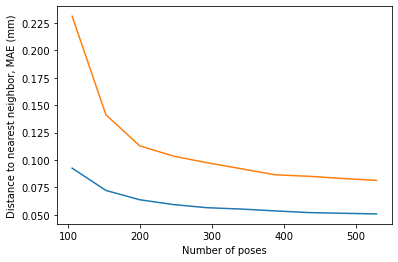

In [43]:
import random 

poses = np.array(poses)
nns_2d = np.array(nns_2d)
nns_3d = np.array(nns_3d)
frac = np.linspace(0.2,1,10)
error2d, error3d = [], []
ind = range(len(poses))
fold = 10
for s in range(fold): #10-fold cross validation
    ind_test = random.sample(ind,int(1/fold*len(ind)))
    diff = set(ind) - set(ind_test)
    
    err2d, err3d = [], []
    for f in frac:
        ind_train = random.sample(diff,int(f*len(diff)))
        
        A_est_2D = best_linear_map(pts2d_source,pts2d_target[poses[ind_train]],nns_2d[ind_train],nn=1)
        A_est_3D = best_linear_map(pts3d_source,pts3d_target[poses[ind_train]],nns_3d[ind_train],nn=1)
        
        pts2d_prism = apply_linear_map(A_est_2D, pts2d_target[poses[ind_test]])
        pts3d_prism = apply_linear_map(A_est_3D, pts3d_target[poses[ind_test]])
        
        err2d.append(np.abs(pts2d_source[nns_2d[ind_test][:,0]] - pts2d_prism).mean())
        err3d.append(np.abs(pts3d_source[nns_3d[ind_test][:,0]] - pts3d_prism).mean())
        
    error2d.append(np.array(err2d))
    error3d.append(np.array(err3d))
    
error2d = np.array(error2d)*2.5/400 #px to mm conversion
error3d = np.array(error3d)#*2.5/400 #px to mm conversion

plt.plot(frac*len(poses)*(1-1/fold), error2d.mean(0))
plt.plot(frac*len(poses)*(1-1/fold), error3d.mean(0))
plt.ylabel('Distance to nearest neighbor, MAE (mm)')
plt.xlabel('Number of poses')
#plt.savefig('cross_validation.svg')

# Find best linear transformation for 2D, d2

In [9]:
nn=2

A_est_2D = best_linear_map(pts2d_source, pts2d_target[poses], nns_2d, nn=nn)
pts2d_prism = apply_linear_map(A_est_2D, pts2d_target)


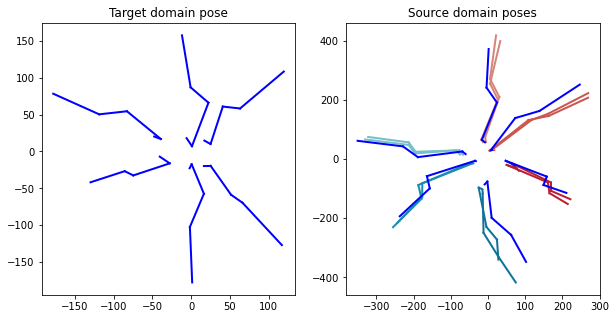

In [10]:
ind = 0

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plot_pose_2d(
    ax, 
    pts2d_target[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
ax.set_title('Target domain pose')

ax = fig.add_subplot(122)
ax.set_title('Source domain poses')

for i in nns_2d[ind][:nn]:
    plot_pose_2d(
        ax, 
        pts2d_source[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
    )
    
plot_pose_2d(
    ax, 
    pts2d_prism[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
plt.savefig('2D_mapping.svg')

# Find best linear transformation for 3D, d3

In [20]:
nn = 1

#L = [i for i in range(15)]
#R = [i for i in range(15,30)]

#L_ind = (keypts_target[:,L,:].max(2).sum(1)>13)
#R_ind = (keypts_target[:,R,:].max(2).sum(1)>13)

#L_ind = np.where(L_ind[poses])[0]
#R_ind = np.where(R_ind[poses])[0]

#nns_L = [nns_3d[i] for i in L_ind]
#nns_R = [nns_3d[i] for i in R_ind]

#A_est_3D_L = best_linear_map(pts3d_source[:,L,:], pts3d_target[poses][L_ind][:,L,:], nns_L, nn=nn)
#A_est_3D_R = best_linear_map(pts3d_source[:,R,:], pts3d_target[poses][R_ind][:,R,:], nns_R, nn=nn)

#A_est_3D = np.block([[A_est_3D_L,                np.zeros_like(A_est_3D_L)],
#                     [np.zeros_like(A_est_3D_R), A_est_3D_R ]])

#A_est_3D = best_linear_map(pts3d_source,pts3d_target[poses],nns_3d,nn=nn)#, vis_pts=keypts_target[poses])

A_est_3D = pickle.load(open('prism_to_DF3D_3D.pkl','rb'))
pts3d_prism = apply_linear_map(A_est_3D, pts3d_target)
    

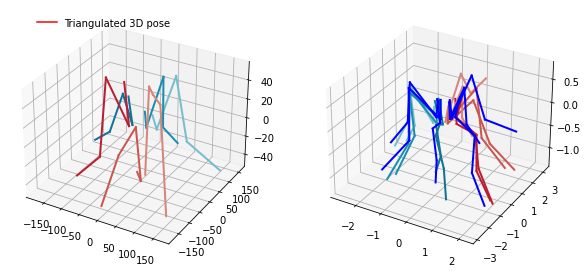

In [12]:
ind = 2
nn=2

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

plot_pose_3d(ax=ax1, tar=pts3d_target[ind],
        #pred=pred,
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"], 
        colors=par_data["vis"]["colors"],
        #good_keypts = keypts_target[ind],
        normalize=False,
        legend=True,
        axes=True)

for i in nns_3d[ind][:nn]:
    plot_pose_3d(
        ax2, 
        pts3d_source[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
        #good_keypts=keypts_target[poses[ind]]
        axes=True
    )   
    
plot_pose_3d(
    ax2, 
    pts3d_prism[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
    #good_keypts=keypts_target[poses[ind]]
    axes=True
)
    
#plt.savefig('3D_mapping.svg')

# Predict poses with trained network

In [24]:
from liftpose.postprocess import load_test_results
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test
from liftpose.lifter.utils import filter_data

kp = keypts_target
        
#normalize test data
test_2d, test_3d, stat_2d, stat_3d = set_test_data(par_train['out_dir'], {'':pts2d_prism.copy()}, {'':pts3d_prism.copy()})
    
#test data on network
lp3d_test(par_train['out_dir'],test_2d, test_3d)
    
#load statistics and test results
gt, pred, _ = load_test_results(par_train['out_dir'], stat_2d, stat_3d)

#filter noise
#test_3d_gt = filter_data(test_3d_gt)
#test_3d_pred = filter_data(test_3d_pred)


[main.py:388]:INFO:starting testing in path: /data/LiftPose3D/domain_adaptation
[lift.py:29]:INFO:Training on the device: cuda:0
[lift.py:56]:INFO:total params: 4.33M
[lift.py:64]:INFO:loading ckpt from '/data/LiftPose3D/domain_adaptation/ckpt_best.pth.tar'
[lift.py:72]:INFO:ckpt loaded (epoch: 29 | err: 0.0435903278757361)
[lift.py:106]:INFO:Saving results: /data/LiftPose3D/domain_adaptation/test_results.pth.tar


# Errors

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[utils.py:145]:INFO:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[utils.py:157]:INFO:NumExpr defaulting to 8 threads.
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved


/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/plot.py:354: RuntimeWarning: Mean of empty slice
  err = np.nanmean(np.abs(gt - pred), axis=-1)
/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/plot.py:356: RuntimeWarning: Mean of empty slice
  err = np.hstack([err, np.nanmean(err, axis=1, keepdims=True)])


[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved
[_base.py:2646]:DEBUG:top of axes not in the figure, so title not moved


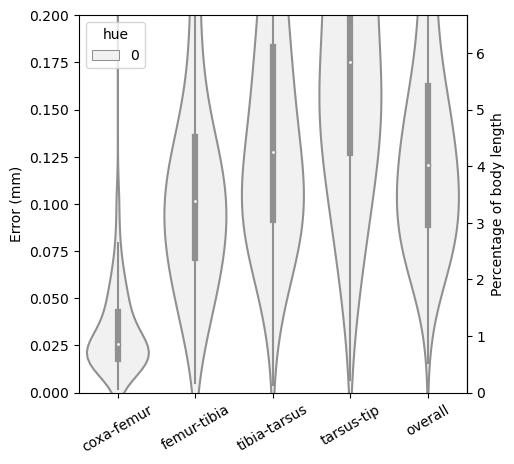

In [25]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(5,5), dpi=100)
names = ['coxa-femur','femur-tibia','tibia-tarsus','tarsus-tip']
ax = plt.gca()
s = gt.shape
gt_reshape = gt.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
pred_reshape = pred.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
kp_reshape = keypts_target.reshape(s[0]*6, s[1]//6, 3)[:,1:,:]
violin_plot(ax, gt=gt_reshape, pred=pred_reshape, good_keypts=kp_reshape,
                name=names, order=names, units='mm', body_length=3)
ax.set_ylim([0,0.2])
plt.savefig('errors.svg')

[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


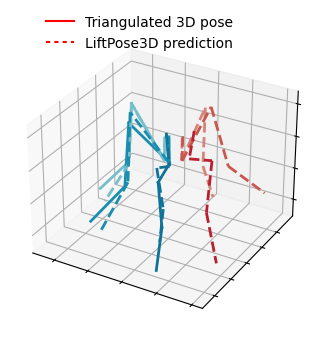

In [26]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

t = 0

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

plot_pose_3d(ax=ax, tar=gt[t], 
            pred=pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=kp[t],
            show_pred_always=True,
            legend=True)

plt.savefig('pose.svg')

# Video

[animation.py:329]:DEBUG:frame size in pixels is 400 x 400
[animation.py:345]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 400x400 -pix_fmt rgba -r 20 -i pipe: -vcodec h264 -pix_fmt yuv420p -y LiftPose3D_prediction.mp4
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWr

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:

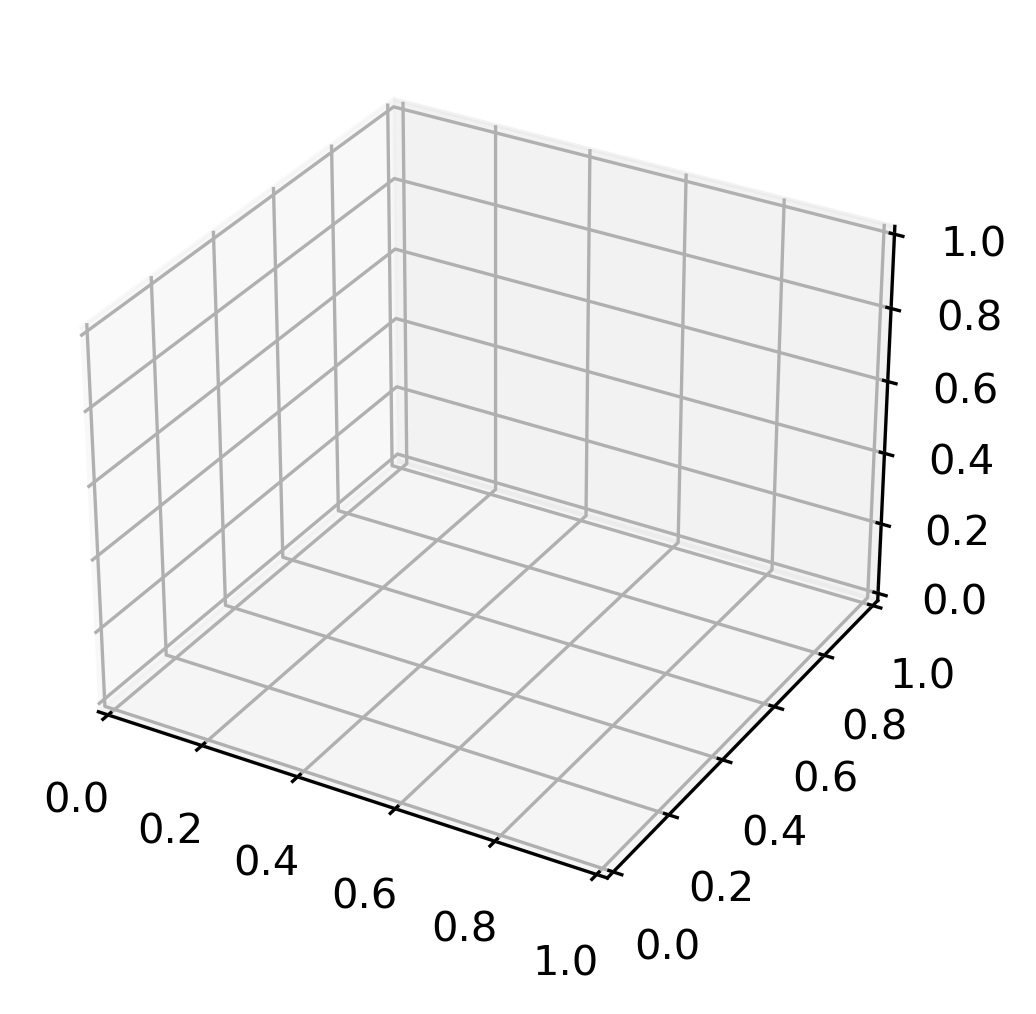

In [41]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=300)
ax = fig.add_subplot(111, projection='3d')

def f(ax, idx):
    ax.cla()

    plot_pose_3d(ax=ax, tar=gt[idx], 
            pred=pred[idx],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=kp[idx],
            show_pred_always=True,
            legend=True)
    
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.set_zlim([-1.5,0.5])
    
plot_video_3d(fig, ax, n=500, fps=20, draw_function=f, name='LiftPose3D_prediction.mp4')